In [1]:
import pandas as pd
import numpy as np
import librosa
import wave as wav
import tensorflow as tf
import scipy
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
from sklearn import metrics
from sklearn.model_selection import cross_validate
import os
import statistics
import math
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import graphviz
from sklearn import tree

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
import sys

from sklearn.metrics import plot_confusion_matrix
import seaborn as sns 
import matplotlib.pyplot as plt
import operator as op
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict
from entropy import *
from random import shuffle

from sklearn.svm import SVC
from sklearn.decomposition import PCA

In [2]:
# !pip install xgboost
# import xgboost as xgb

You should consider upgrading via the '/gpfs/hpc/home/rannilo/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
root = "respiratory_sound_database/"
patient_diagnosis = pd.read_csv(root+"patient_diagnosis.csv", names=["patient", "diagnosis"])
demographic_info = pd.read_csv(root+"demographic_info.txt", delimiter=" ", names=["patient", "age", "sex", "bmi", "weight", "height"])

train_patients = pd.read_csv(root + "train_patients.csv")
test_patients = pd.read_csv(root + "test_patients.csv")

train_patients.set_index("patient", inplace=True)
test_patients.set_index("patient", inplace=True)
patient_diagnosis.set_index("patient", inplace=True)
demographic_info.set_index("patient", inplace=True)

In [3]:
train_patients.head()

""
patient
101
102
103
104
105


In [4]:
test_patients.head()

""
patient
185
186
187
188
189


In [5]:
patient_diagnosis.head()

,diagnosis
patient,
101,URTI
102,Healthy
103,Asthma
104,COPD
105,URTI


In [6]:
demographic_info.head()

,age,sex,bmi,weight,height
patient,,,,,
101,3.00,F,NaN,19.0,99.0
102,0.75,F,NaN,9.8,73.0
103,70.00,F,33.00,NaN,NaN
104,70.00,F,28.47,NaN,NaN
105,7.00,F,NaN,32.0,135.0


In [7]:
# data = pd.concat([demographic_info, patient_diagnosis], axis=1)
data = patient_diagnosis

In [8]:
data.head(50)

,diagnosis
patient,
101,URTI
102,Healthy
103,Asthma
104,COPD
105,URTI
106,COPD
107,COPD
108,LRTI
109,COPD


In [9]:
print(data.isna().sum())

diagnosis    0
dtype: int64


In [11]:
#Dropping one patient with NA age and sex
data.dropna(thresh=2, inplace=True)

In [12]:
print(data.isna().sum())


age           0
sex           0
bmi          50
weight       81
height       83
diagnosis     0
dtype: int64


In [10]:
data.count()

diagnosis    126
dtype: int64

Text(0.5, 1.0, "Count of patients' diagnoses")

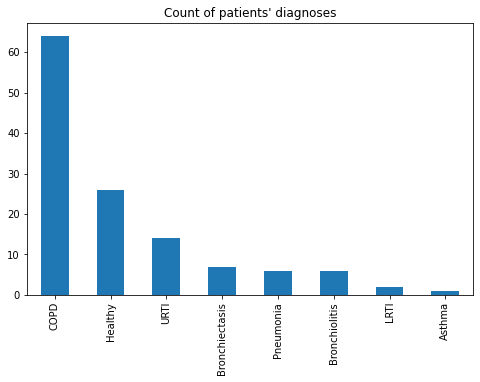

In [11]:
plt.figure(figsize=(8,5))
data.diagnosis.value_counts().plot(kind="bar")
plt.title("Count of patients' diagnoses")

In [12]:
data.diagnosis.value_counts()

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: diagnosis, dtype: int64

In [13]:
#Dropping Asthma and LRTI patients because there are too few of them
data = data.drop(data[(data.diagnosis=='Asthma') | (data.diagnosis == 'LRTI')].index)

In [15]:
data.diagnosis.value_counts()

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
Name: diagnosis, dtype: int64

In [16]:
# #Sex and diagnosis to numerical variables
# sex_categorical, sex_classes = pd.factorize(data["sex"])
diagn_categorical, diagn_classes = pd.factorize(data["diagnosis"])

In [17]:
diagn_classes

Index(['URTI', 'Healthy', 'COPD', 'Bronchiectasis', 'Pneumonia',
       'Bronchiolitis'],
      dtype='object')

In [18]:
data["diagnosis"] = diagn_categorical
# data["sex"] = sex_categorical

In [19]:
data.head()

,diagnosis
patient,
101,0
102,1
104,2
105,0
106,2


In [20]:
# #Replace missing BMI values by using existing weight and height data
# data["bmi_2"] = data.apply(lambda row: (row[3]/(row[4])**2)*10000, axis=1)
# data["bmi"] = data["bmi"].combine_first(data["bmi_2"])
# data.drop(axis=1, columns=["bmi_2"], inplace=True)
# data.head(20)

In [21]:
data.isna().sum()

diagnosis    0
dtype: int64

In [24]:
#Replacing missing BMI information by using similar data, discarding the rest

In [22]:
# missing_data_indexes = [i for i, val in enumerate(data["bmi"].isnull()) if val == True]
# missing_data = data.iloc[missing_data_indexes]
# missing_data

In [29]:
# for idx, row in missing_data.iterrows():
#     age = row[0]
#     sex = row[1]
#     bmi = row[2]
#     diagnosis = row[5]
    
#     similar_patients = data[(data['sex'] == sex)
#                            & (data['diagnosis'] == diagnosis)
#                            & (age - 5 <= data['age']) & (data['age'] <= age + 5) 
#                             & (data['bmi'].isnull()==False) ]
    
#     if (len(similar_patients) > 2):
#         print("Found a similar BMI match for index", idx)
#         data.at[idx, "bmi"] = similar_patients.bmi.mean()
#     else:
#         print("Dropping index", idx)
#         data = data.drop(idx)

In [23]:
data.isna().sum()

diagnosis    0
dtype: int64

In [31]:
# #Dropping weight and height columns, because they have a lot of missing data
# data = data.drop(columns=["weight", "height"])
# data = data.dropna()

In [32]:
data.isna().sum()

age          0
sex          0
bmi          0
diagnosis    0
dtype: int64

In [24]:
data.describe()

,diagnosis
count,123.000000
mean,1.861789
std,1.161720
min,0.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,5.000000


In [25]:
all_diagnosis_data = data["diagnosis"]

In [37]:
#Adding crackles and wheezes count
#1. Load in training and test sound files
#2. Put them in one dataframe
#3. Iterate through them. 
#4. If the patient number is not one found in the "data" dataframe, discard it
#5. Put the wheezes per soundfile/crackles per soundfile information into a python array:
#[[patient, wheezes, crackles], ...]
#6. Make that into a numpy array, that into a pandas dataframe
#7. Group by patient number by taking the mean
#8. Sort by patient number
#9. Put into the "data" dataframe.
#Train

In [26]:
test_soundfiles = pd.read_csv(root + "test_soundfiles.csv")
train_soundfiles = pd.read_csv(root + "train_soundfiles.csv")

In [27]:
soundfiles = pd.concat([train_soundfiles, test_soundfiles])

In [28]:
soundfiles

,filename
0,101_1b1_Al_sc_Meditron.wav
1,101_1b1_Pr_sc_Meditron.wav
2,102_1b1_Ar_sc_Meditron.wav
3,104_1b1_Al_sc_Litt3200.wav
4,104_1b1_Ar_sc_Litt3200.wav
...,...
267,224_1b2_Al_sc_Meditron.wav
268,225_1b1_Pl_sc_Meditron.wav
269,226_1b1_Al_sc_Meditron.wav
270,226_1b1_Ll_sc_Meditron.wav


In [30]:
array = [3,5,3,4,2]
SAMPLE_RATE = 16000
filename = "226_1b1_Pl_sc_LittC2SE.wav"
raw, sr = librosa.load(root + "audio_and_txt_files/" + filename, sr = SAMPLE_RATE, duration=20)
mfccs = librosa.feature.mfcc(raw, hop_length=20*16000, n_mfcc=8)
array.extend(mfccs.flatten())
array

<ipython-input-30-942ecda8bdb1>:5: FutureWarning: Pass y=[-0.06110961 -0.0989821  -0.08477858 ...  0.02802622  0.02782768
  0.03067384] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(raw, hop_length=20*16000, n_mfcc=8)


[3,
 5,
 3,
 4,
 2,
 -285.27277,
 -376.13107,
 125.80637,
 116.6147,
 13.838173,
 32.383488,
 35.18323,
 25.728489,
 11.492977,
 17.830505,
 22.694141,
 12.693299,
 8.004244,
 11.11594,
 16.525215,
 9.836065]

In [31]:
(20*16000)/8

40000.0

In [32]:
soundfiles

,filename
0,101_1b1_Al_sc_Meditron.wav
1,101_1b1_Pr_sc_Meditron.wav
2,102_1b1_Ar_sc_Meditron.wav
3,104_1b1_Al_sc_Litt3200.wav
4,104_1b1_Ar_sc_Litt3200.wav
...,...
267,224_1b2_Al_sc_Meditron.wav
268,225_1b1_Pl_sc_Meditron.wav
269,226_1b1_Al_sc_Meditron.wav
270,226_1b1_Ll_sc_Meditron.wav


In [1]:
#This might take a while
import antropy as ant
breathing_data_array = []
print("START!")
for i, row in soundfiles.iterrows():
    print("Index " + str(i))
    print(row[0])
    
    filename = row[0]
    patient = int(row[0].split("_")[0])
    try: 
        data.loc[patient]
    except KeyError:
        continue
    
    # txt_filename = filename[:-4] + ".txt"
    # annotations = pd.read_csv(root + "audio_and_txt_files/" + txt_filename, names=["start", "stop", "crackle", "wheeze"], sep="\t")
    # total_crackles = annotations.crackle.sum()
    # total_wheeze = annotations.wheeze.sum()
    # total_time = annotations.iloc[-1, 1] - annotations.iloc[0, 0]
    # crackle_per_sec = round(total_crackles/total_time, 4)
    # wheeze_per_sec = round(total_wheeze/total_time, 4)
        
    #Extracting sound features
    SAMPLE_RATE = 16000
    raw, sr = librosa.load(root + "audio_and_txt_files/" + filename, sr = SAMPLE_RATE)
    zcr = librosa.core.zero_crossings(raw).sum() / len(raw)
    sc = librosa.feature.spectral_centroid(raw)[0]
    rms = librosa.feature.rms(raw)[0]
    s_rf = librosa.feature.spectral_rolloff(raw, roll_percent=0.85)[0]
    s_rf_75 = librosa.feature.spectral_rolloff(raw, roll_percent=0.75)[0]
    sf = librosa.feature.spectral_flatness(raw)[0]
    se = ant.spectral_entropy(x = raw, sf = sr, method='fft')
    mfccs = librosa.feature.mfcc(raw, hop_length=len(raw), n_mfcc=8)
    mfccs = mfccs.flatten()
    
    add_to_array=[patient,
                 zcr,
                 sc.mean(),
                 np.median(sc),
                 sc.std(),
                 rms.mean(),
                 np.median(rms),
                 rms.std(), 
                 s_rf.mean(), 
                 np.median(s_rf),
                 s_rf.std(),
                 s_rf_75.mean(), 
                 np.median(s_rf_75),
                 s_rf_75.std(),
                sf.mean(),
                np.median(sf),
                sf.std(),
                se]
    add_to_array.extend(mfccs)
    
    breathing_data_array.append(add_to_array)

In [38]:
data_columns = ["patient",
                "zero_crossing_rate", 
                "spectral_centroid_mean", 
                "spectral_centroid_median",
                "spectral_centroid_std", 
                "root_mean_square_mean", 
                "root_mean_square_median", 
                "root_mean_square_std", 
                "spectral_rolloff_85_mean", 
                "spectral_rolloff_85_median", 
                "spectral_rolloff_85_std",
               "spectral_rolloff_75_mean", 
                "spectral_rolloff_75_median", 
                "spectral_rolloff_75_std",
               "spectral_flatness_mean",
               "spectral_flatness_median",
               "spectral_flatness_std",
               "spectral_entropy",
               "mfcc1",
               "mfcc2",
               "mfcc3",
               "mfcc4",
               "mfcc5",
               "mfcc6",
               "mfcc7",
               "mfcc8",
               "mfcc9",
               "mfcc10",
               "mfcc11",
               "mfcc12",
               "mfcc13",
               "mfcc14",
               "mfcc15",
               "mfcc16"]

In [39]:
np_breathing_data_array = np.array(breathing_data_array)
np_breathing_data_array.shape

(917, 34)

In [40]:
breathing_data_df = pd.DataFrame(np_breathing_data_array, columns=data_columns)
breathing_data_df.set_index("patient", inplace=True)
breathing_data_df = breathing_data_df.groupby(by="patient").mean()

In [41]:
data.head()

,diagnosis
patient,
101,0
102,1
104,2
105,0
106,2


In [42]:
data = pd.merge(left = data, right = breathing_data_df, left_index=True, right_index=True)

In [52]:
data.tail()

,diagnosis,zero_crossing_rate,spectral_centroid_mean,spectral_centroid_median,spectral_centroid_std,root_mean_square_mean,root_mean_square_median,root_mean_square_std,spectral_rolloff_85_mean,spectral_rolloff_85_median,...,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16
patient,,,,,,,,,,,,,,,,,,,,,
222.0,2,0.001962,87.973154,74.352573,60.144119,0.262626,0.218038,0.150184,107.288526,71.777344,...,24.703486,16.106707,21.100173,31.723652,13.592641,11.612599,10.559210,4.717309,11.968887,14.505526
223.0,2,0.001429,120.142143,104.791262,71.810668,0.261914,0.235259,0.122984,91.240276,57.421875,...,32.523426,41.160992,12.237688,5.164334,21.111019,23.719230,8.630318,7.783504,12.677872,11.371715
224.0,1,0.002389,221.320155,193.802162,130.773998,0.061126,0.058770,0.027410,118.914190,80.749512,...,34.526129,21.052407,10.101821,16.178956,21.252956,12.626164,6.689349,11.018046,15.452478,8.372151
225.0,1,0.003059,162.208720,130.190785,105.784403,0.049908,0.047129,0.019001,178.852859,86.132812,...,33.569832,12.644453,9.453696,8.094234,21.282808,6.673789,6.579703,6.620239,15.480480,5.829107
226.0,4,0.003206,146.384047,130.292743,93.174061,0.068840,0.064819,0.025096,169.049404,100.488281,...,34.824655,23.033574,11.628225,17.327045,22.989255,13.178257,7.750063,11.508230,16.029374,9.338048


In [44]:
test_data = pd.merge(left = test_patients, right = data, left_index=True, right_index=True)
train_data = pd.merge(left = train_patients, right = data, left_index=True, right_index=True)

In [53]:
data

,diagnosis,zero_crossing_rate,spectral_centroid_mean,spectral_centroid_median,spectral_centroid_std,root_mean_square_mean,root_mean_square_median,root_mean_square_std,spectral_rolloff_85_mean,spectral_rolloff_85_median,...,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16
patient,,,,,,,,,,,,,,,,,,,,,
101.0,0,0.002703,145.907974,132.897698,80.499597,0.045906,0.043956,0.015496,129.930178,102.282715,...,33.882719,26.100874,9.883459,19.923167,21.763529,15.538423,6.648538,13.444543,15.291958,10.434458
102.0,1,0.003019,194.959576,183.694647,74.179136,0.022426,0.021317,0.008030,194.469591,161.499023,...,-22.417553,28.517933,-7.581968,14.792792,44.441593,3.901180,20.310940,-1.075218,3.679981,-2.306754
104.0,2,0.007287,149.068986,123.309020,93.979109,0.058883,0.045448,0.046155,289.526145,218.920898,...,-5.433207,17.079572,-4.765042,31.368672,15.671483,9.827294,22.432210,2.534823,23.480220,14.030258
105.0,0,0.069128,1072.966123,1134.265069,214.532435,0.028946,0.027611,0.012954,1711.769255,1744.189453,...,-9.396896,23.365917,25.854355,31.040987,5.761407,18.151335,1.027621,10.816775,2.934234,17.734602
106.0,2,0.007709,395.837608,370.268637,180.749856,0.098769,0.088583,0.044479,596.849825,336.456299,...,42.113716,34.795153,14.746895,25.910447,20.821955,19.720680,4.071386,15.422226,13.257470,10.313030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222.0,2,0.001962,87.973154,74.352573,60.144119,0.262626,0.218038,0.150184,107.288526,71.777344,...,24.703486,16.106707,21.100173,31.723652,13.592641,11.612599,10.559210,4.717309,11.968887,14.505526
223.0,2,0.001429,120.142143,104.791262,71.810668,0.261914,0.235259,0.122984,91.240276,57.421875,...,32.523426,41.160992,12.237688,5.164334,21.111019,23.719230,8.630318,7.783504,12.677872,11.371715
224.0,1,0.002389,221.320155,193.802162,130.773998,0.061126,0.058770,0.027410,118.914190,80.749512,...,34.526129,21.052407,10.101821,16.178956,21.252956,12.626164,6.689349,11.018046,15.452478,8.372151


In [54]:
data.to_csv(root + "dataframes/sound_diagnosis.csv")

In [45]:
train_data.head()

,diagnosis,zero_crossing_rate,spectral_centroid_mean,spectral_centroid_median,spectral_centroid_std,root_mean_square_mean,root_mean_square_median,root_mean_square_std,spectral_rolloff_85_mean,spectral_rolloff_85_median,...,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16
patient,,,,,,,,,,,,,,,,,,,,,
101.0,0,0.002703,145.907974,132.897698,80.499597,0.045906,0.043956,0.015496,129.930178,102.282715,...,33.882719,26.100874,9.883459,19.923167,21.763529,15.538423,6.648538,13.444543,15.291958,10.434458
102.0,1,0.003019,194.959576,183.694647,74.179136,0.022426,0.021317,0.008030,194.469591,161.499023,...,-22.417553,28.517933,-7.581968,14.792792,44.441593,3.901180,20.310940,-1.075218,3.679981,-2.306754
104.0,2,0.007287,149.068986,123.309020,93.979109,0.058883,0.045448,0.046155,289.526145,218.920898,...,-5.433207,17.079572,-4.765042,31.368672,15.671483,9.827294,22.432210,2.534823,23.480220,14.030258
105.0,0,0.069128,1072.966123,1134.265069,214.532435,0.028946,0.027611,0.012954,1711.769255,1744.189453,...,-9.396896,23.365917,25.854355,31.040987,5.761407,18.151335,1.027621,10.816775,2.934234,17.734602
106.0,2,0.007709,395.837608,370.268637,180.749856,0.098769,0.088583,0.044479,596.849825,336.456299,...,42.113716,34.795153,14.746895,25.910447,20.821955,19.720680,4.071386,15.422226,13.257470,10.313030


In [46]:
test_data.head()

,diagnosis,zero_crossing_rate,spectral_centroid_mean,spectral_centroid_median,spectral_centroid_std,root_mean_square_mean,root_mean_square_median,root_mean_square_std,spectral_rolloff_85_mean,spectral_rolloff_85_median,...,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16
patient,,,,,,,,,,,,,,,,,,,,,
185.0,2,0.006029,115.329483,90.588596,69.496591,0.070777,0.053971,0.052810,197.049547,127.404785,...,9.158581,17.844003,-1.277806,33.411126,13.668727,12.834984,24.989796,3.583437,28.812774,16.943030
186.0,2,0.006717,503.272442,479.137521,164.860530,0.178882,0.168659,0.068151,588.046065,462.066650,...,0.000000,29.129896,0.000000,20.827367,0.000000,17.921813,0.000000,12.487509,0.000000,11.596122
187.0,1,0.002281,212.648996,187.101442,141.580718,0.127385,0.087860,0.097096,152.005151,75.366211,...,32.212250,22.978436,8.647223,18.389519,19.955122,11.079656,5.579035,6.668088,14.539810,5.377315
188.0,0,0.006256,223.258870,198.120790,120.457862,0.057547,0.055260,0.020751,403.089695,362.026978,...,31.628926,13.362579,18.987808,20.855360,26.189333,22.175377,6.565960,15.637239,13.553784,11.000881
189.0,2,0.005897,481.086008,469.312888,134.700575,0.003799,0.003694,0.001063,375.403534,312.231445,...,47.543278,21.478603,29.911898,16.341223,34.713875,12.114771,18.685509,9.870472,21.317078,7.207002


In [47]:
y_train = train_data.pop("diagnosis")
y_test = test_data.pop("diagnosis")

In [48]:
#NORMALIZATION

norm_train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())
norm_test_data = (test_data - train_data.min()) / (train_data.max() - train_data.min())

In [49]:
norm_train_data

,zero_crossing_rate,spectral_centroid_mean,spectral_centroid_median,spectral_centroid_std,root_mean_square_mean,root_mean_square_median,root_mean_square_std,spectral_rolloff_85_mean,spectral_rolloff_85_median,spectral_rolloff_85_std,...,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16
patient,,,,,,,,,,,,,,,,,,,,,
101.0,0.017034,0.088761,0.078603,0.175404,0.139656,0.153482,0.075736,0.032546,0.025213,0.155934,...,0.855612,0.659425,0.514381,0.452080,0.489711,0.391192,0.534136,0.759840,0.507656,0.580398
102.0,0.021704,0.136976,0.125343,0.151367,0.061943,0.067576,0.036234,0.070172,0.057461,0.124777,...,0.182178,0.711122,0.000000,0.313202,1.000000,0.030921,0.937390,0.334124,0.122167,0.018760
104.0,0.084867,0.091868,0.069780,0.226669,0.182606,0.159141,0.237965,0.125589,0.088733,0.209936,...,0.385336,0.466477,0.082962,0.761909,0.352631,0.214384,1.000000,0.439969,0.779487,0.738903
105.0,1.000000,1.000000,1.000000,0.685148,0.083524,0.091456,0.062288,0.954739,0.919378,0.590400,...,0.337925,0.600930,0.984747,0.753038,0.129640,0.472083,0.368232,0.682794,0.097410,0.902192
106.0,0.091117,0.334426,0.297017,0.556669,0.314617,0.322824,0.229095,0.304755,0.152741,0.568102,...,0.954067,0.845380,0.657616,0.614155,0.468524,0.520668,0.458070,0.817825,0.440116,0.575046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180.0,0.129074,0.343540,0.317424,0.393560,0.620202,0.666601,0.328558,0.253376,0.218118,0.329618,...,0.450325,0.587929,0.223300,0.394422,0.000000,0.284331,0.337901,0.651799,0.000000,0.521386
181.0,0.148101,0.410204,0.374439,0.547571,0.012410,0.012491,0.012635,0.310009,0.275872,0.448993,...,0.667253,0.358206,0.274889,0.106946,0.180527,0.526367,0.363505,0.726986,0.434101,0.487051
182.0,0.020594,0.117866,0.097658,0.230044,0.107288,0.107932,0.080734,0.066472,0.022281,0.217286,...,0.855351,0.508123,0.511149,0.228737,0.484494,0.000000,0.533257,0.272257,0.508424,0.222393


In [51]:
#Uncomment to save the training and test data for later use here

norm_train_data.to_csv(root + "dataframes/norm_train_data_sound_features_03_31.csv")
norm_test_data.to_csv(root + "dataframes/norm_test_data_sound_features_03_31.csv")

train_data.to_csv(root + "dataframes/train_data_sound_features_03_31.csv")
test_data.to_csv(root + "dataframes/test_data_sound_features_03_31.csv")

In [4]:
#Uncomment to check if saving was successful

#train_data = pd.read_csv(root + "dataframes/train_data_sound_features_03_31.csv")
#test_data = pd.read_csv(root + "dataframes/test_data_sound_features_03_31.csv")